# Selection of Study Region

This notebook is used to defined the study region for the project. 

The study region was selected based on this criteria:
1. State of New York
2. HUC-6 (6 digits) basin
3. Should have included at least one of the counties: UlSter, Orange, Delware, Sullivan, Greene

In [1]:
# Import packages
import geopandas as gpd
from pathlib import Path
from plotnine import *
import json
import pandas as pd

In [2]:
# File paths
project_base_path = Path.cwd().parent.parent 
shapefiles_base_path = project_base_path / 'data'/'shapefiles'
us_county_path = shapefiles_base_path / 'tl_2024_us_county' / 'tl_2024_us_county.shp'
us_state_path =  shapefiles_base_path / 'tl_2024_us_state' / 'tl_2024_us_state.shp'

In [48]:
# Load files
us_state = gpd.read_file(us_state_path)
us_county = gpd.read_file(us_county_path)

if us_state.crs != us_county.crs:
    print('The CRS differs from each other. Converting CRS')
    us_county = us_county.to_crs(us_state.crs)
else:
    print('Both files are in the same CRS')


Both files are in the same CRS


In [4]:
# Selecting states
states_to_keep = ['New York', 'Pennsylvania', 'Connecticut', 'Massachusetts', 'Vermont']
us_eastern = us_state[us_state['NAME'].isin(states_to_keep)]
us_eastern.shape

(5, 16)

## Selecting the State of New York

In order to download the watershed shapefile, it is necessary to provide the boundary box of required region

C:\Users\esanttos\AppData\Local\Temp\ipykernel_6796\151164394.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

C:\Users\esanttos\AppData\Local\Temp\ipykernel_6796\151164394.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



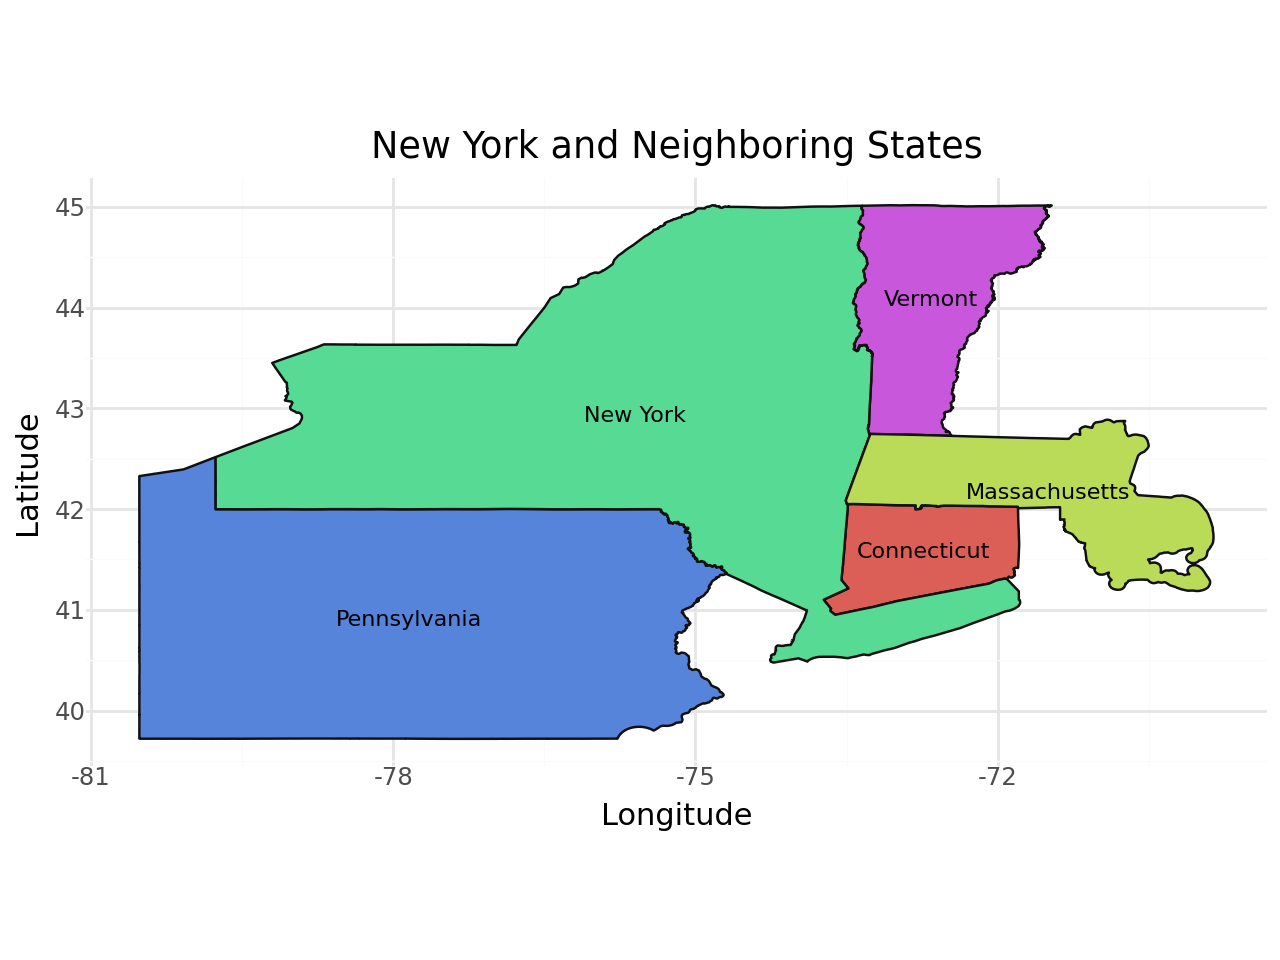

In [106]:
# Define the centroid of each polygon
us_eastern["lon"] = us_eastern.geometry.centroid.x
us_eastern["lat"] = us_eastern.geometry.centroid.y


us_eastern_map = (
    ggplot(us_eastern)
    + geom_map(
        mapping=aes(fill="NAME", geometry="geometry"),
        data=us_eastern,
        inherit_aes=False
    )
    + geom_text(
        mapping=aes(x="lon", y="lat", label="NAME"),
        size=8,
        color="black"
    )
    + coord_fixed()
    + theme_minimal()
    + theme(legend_position="none", panel_grid_major=None, panel_grid_minor=None)
    + labs(title="New York and Neighboring States", x="Longitude", y="Latitude")
)

us_eastern_map

In [48]:
# Boundary box
minx, miny, maxx, maxy =  (us_eastern.union_all()).bounds

bottom_left = (minx, miny)
bottom_right = (maxx, miny)
top_right = (maxx, maxy)
top_left = (minx, maxy)

bbox = dict(bottom_left = bottom_left, bottom_right = bottom_right, top_right=top_right, top_left=top_left)

try:
    # Export in Json format
    with open(project_base_path / 'data' / 'other' / 'ny_neighboring_bbox.json', 'w') as f:
        json.dump(bbox, f, indent=4)
    print('File with boundary box sucessuflly saved locally as json.')
except Exception as err:
    print(f'Failed to save boundary box as json file: {err}')

C:\Users\esanttos\AppData\Local\Temp\ipykernel_4908\1018381951.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.


## Selection of subbasin

In [49]:
WB_01_HU2_U2_path = shapefiles_base_path / 'WBD_01_HU2_Shape' / 'Shape' / 'WBDHU2.shp'
WB_02_HU2_U2_path = shapefiles_base_path / 'WBD_02_HU2_Shape' / 'Shape' / 'WBDHU2.shp'
WB_04_HU2_U2_path = shapefiles_base_path / 'WBD_04_HU2_Shape' / 'Shape' / 'WBDHU2.shp'
WB_05_HU2_U2_path = shapefiles_base_path / 'WBD_05_HU2_Shape' / 'Shape' / 'WBDHU2.shp'

# Load Watershed Boundaries
WB_01_HU2_U2 = gpd.read_file(WB_01_HU2_U2_path)
WB_02_HU2_U2 = gpd.read_file(WB_02_HU2_U2_path)
WB_04_HU2_U2 = gpd.read_file(WB_04_HU2_U2_path)
WB_05_HU2_U2 = gpd.read_file(WB_05_HU2_U2_path)

if not (WB_01_HU2_U2.crs == WB_02_HU2_U2.crs == WB_04_HU2_U2.crs == WB_05_HU2_U2.crs == us_state.crs):
    print('One or more file is not in the same CRS as us_states. Changing CRS must be perfomed befores continuing')
else:
    print('All shapfiles are in the CRS.')

All shapfiles are in the CRS.


C:\Users\esanttos\AppData\Local\Temp\ipykernel_6796\475297313.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

C:\Users\esanttos\AppData\Local\Temp\ipykernel_6796\475297313.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



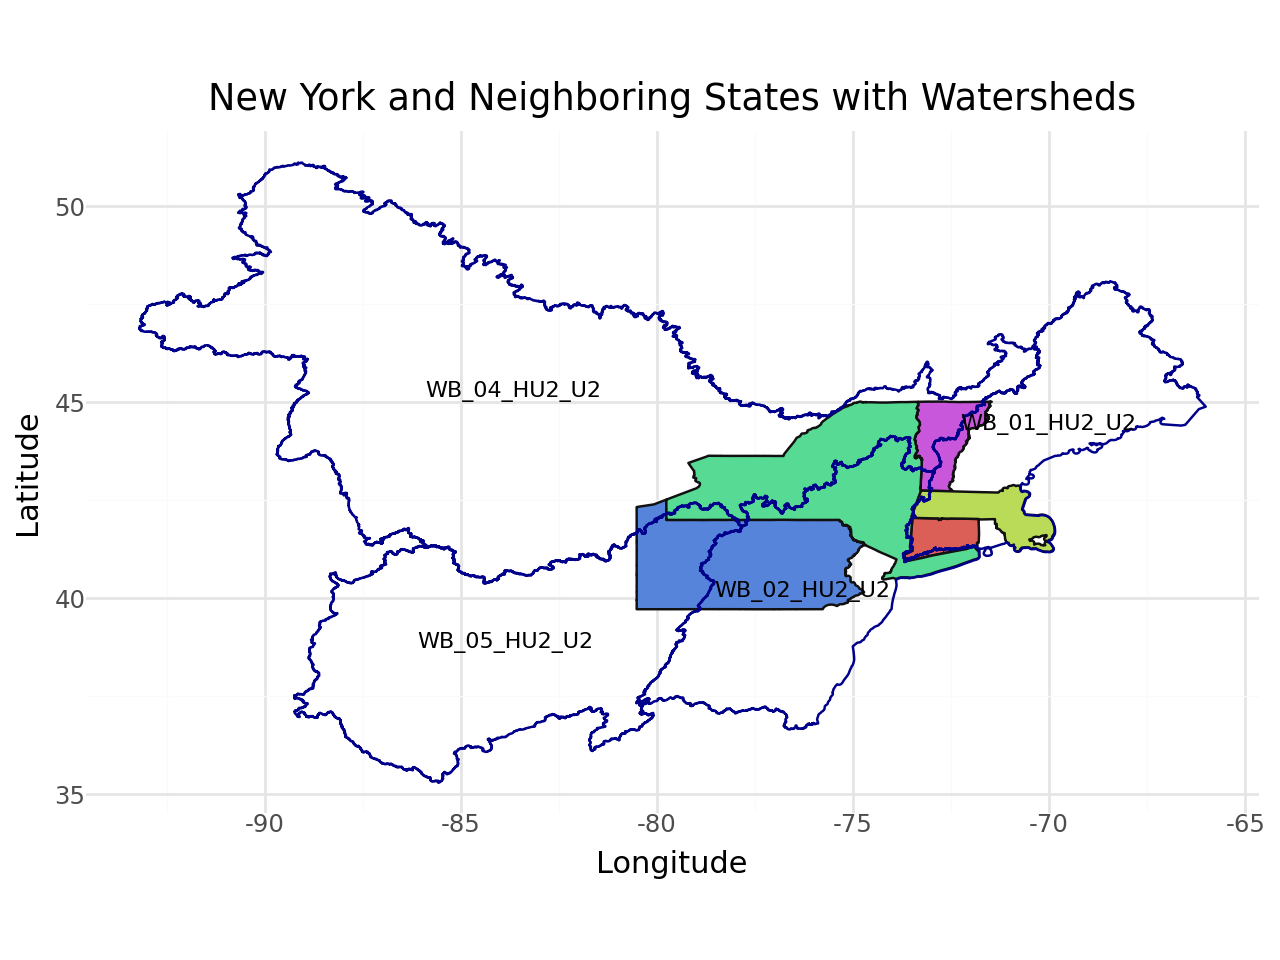

In [104]:
# Dictionary mapping object names to the objects
WB_objects = {
    "WB_01_HU2_U2": WB_01_HU2_U2,
    "WB_02_HU2_U2": WB_02_HU2_U2,
    "WB_04_HU2_U2": WB_04_HU2_U2,
    "WB_05_HU2_U2": WB_05_HU2_U2
}

# Create the DataFrame to show shapefile name on map
WB_HU2_DESC = pd.DataFrame({
    'lon': [float(source.geometry.centroid.x.iloc[0]) for source in WB_objects.values()],
    'lat': [float(source.geometry.centroid.y.iloc[0]) for source in WB_objects.values()],
    'desc': [name for name in WB_objects.keys()]
})

# Map
basin_map = (
    ggplot()
    + geom_map(
        mapping=aes(fill="NAME", geometry="geometry"),
        data=us_eastern,
        inherit_aes=False
    )
    + coord_fixed()
    + theme_minimal()
    + theme(legend_position="none", panel_grid_major=None, panel_grid_minor=None)
    + labs(title="New York and Neighboring States with Watersheds", x="Longitude", y="Latitude")
    + geom_map(
        mapping=aes(geometry="geometry"),
        data=WB_01_HU2_U2,
        inherit_aes=False,
        color='darkblue',
        fill=None
    )
    + geom_map(
        mapping=aes(geometry="geometry"),
        data=WB_02_HU2_U2,
        inherit_aes=False,
        color='darkblue',
        fill=None
    )
    + geom_map(
        mapping=aes(geometry="geometry"),
        data=WB_04_HU2_U2,
        inherit_aes=False,
        color='darkblue',
        fill=None
    )
    + geom_map(
        mapping=aes(geometry="geometry"),
        data=WB_05_HU2_U2,
        inherit_aes=False,
        color='darkblue',
        fill=None
    )
    + geom_text(
        mapping=aes(x='lon', y="lat", label='desc'),
        data=WB_HU2_DESC,
        inherit_aes=False,
        size=8,
        color="black"
    )
)
basin_map


From the map avobe it seems `WB_02_HU2_U2` better fits our criteria. Let's verify the third criteria: "should have included at least one of the counties: _UlSter, Orange, Delware, Sullivan, Greene_"

In [96]:
ny_state_fp = us_state[us_state['NAME'] == 'New York']['STATEFP'].iloc[0]
ny_counties = us_county[us_county['STATEFP'] == ny_state_fp]

counties_of_interest = ['Ulster', 'Orange', 'Delaware', 'Sullivan', 'Greene']

intersecting_counties_geom =  gpd.clip(gdf=ny_counties, mask=WB_02_HU2_U2)
intersecting_counties_of_interest = [county for county in counties_of_interest if county in list(intersecting_counties_geom['NAME'])]

if intersecting_counties_of_interest:
    print(f'The following counties of itnerest intersects with the watershed: {", ".join(intersecting_counties_of_interest)}')
else:
    print('No county of interest intersects with the Watershed Bounday')
    print(counties_of_interest)



The following counties of itnerest intersects with the watershed: Ulster, Orange, Delaware, Sullivan, Greene


In [101]:
ny_counties.shape

(62, 19)

HUC2 watershed boundary is too big and goes beyond our limit area. Lets select a smaller subbasin to work with.

C:\Users\esanttos\AppData\Local\Temp\ipykernel_6796\1609772487.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

C:\Users\esanttos\AppData\Local\Temp\ipykernel_6796\1609772487.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



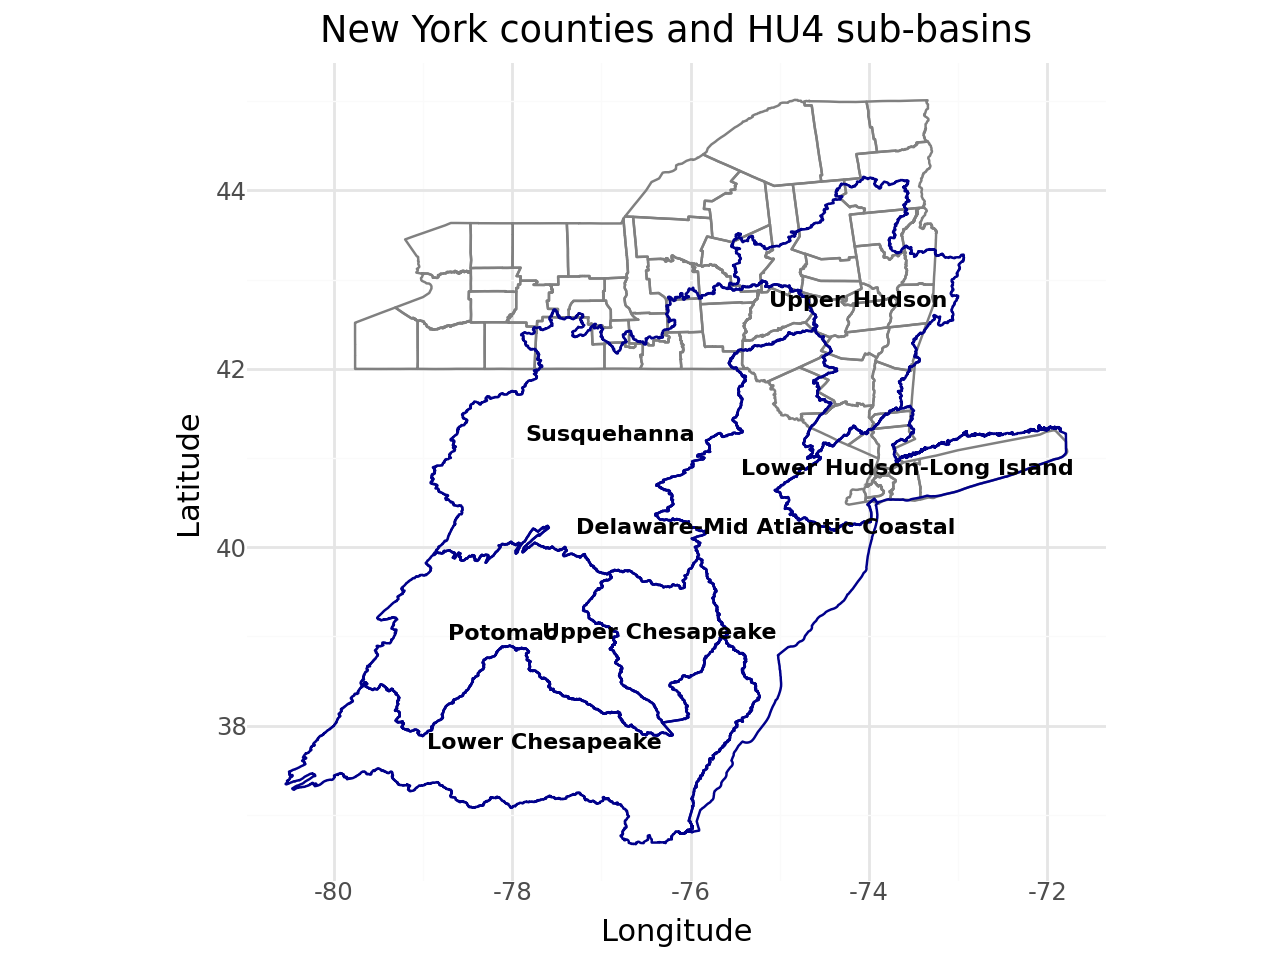

In [119]:
# Load the data
WB_02_HU2_U4_path = shapefiles_base_path / 'WBD_02_HU2_Shape' / 'Shape' / 'WBDHU4.shp'
WB_02_HU2_U4 = gpd.read_file(WB_02_HU2_U4_path)

# Define the centroid of each polygon
WB_02_HU2_U4["lon"] = WB_02_HU2_U4.geometry.centroid.x
WB_02_HU2_U4["lat"] = WB_02_HU2_U4.geometry.centroid.y

u4_sub_basin_map = (
    ggplot()
    + geom_map(
        mapping=aes(geometry="geometry"),
        data=ny_counties,
        inherit_aes=False,
        fill=None,
        color = 'grey'
    )
    + coord_fixed()
    + theme_minimal()
    + theme(legend_position="none", panel_grid_major=None, panel_grid_minor=None)
    + labs(title="New York counties and HU4 sub-basins", x="Longitude", y="Latitude")
    + geom_map(
        mapping=aes(geometry="geometry"),
        data=WB_02_HU2_U4,
        inherit_aes=False,
        color='darkblue',
        fill=None
    )
    + geom_text(
        mapping=aes(x='lon', y="lat", label='name'),
        data=WB_02_HU2_U4,
        inherit_aes=False,
        size=8,
        fontweight = 'bold',
        color="black"
    )
)
u4_sub_basin_map


In [113]:
WB_02_HU2_U4.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tnmid       7 non-null      object        
 1   metasource  6 non-null      object        
 2   sourcedata  6 non-null      object        
 3   sourceorig  6 non-null      object        
 4   sourcefeat  0 non-null      object        
 5   loaddate    7 non-null      datetime64[ms]
 6   referenceg  6 non-null      object        
 7   areaacres   7 non-null      float64       
 8   areasqkm    7 non-null      float64       
 9   states      7 non-null      object        
 10  huc4        7 non-null      object        
 11  name        7 non-null      object        
 12  shape_Leng  0 non-null      float64       
 13  shape_Area  0 non-null      float64       
 14  ObjectID    7 non-null      int32         
 15  geometry    7 non-null      geometry      
dtypes: datetime64[ms](1), 